<a href="https://colab.research.google.com/github/yonigresearch-wq/ML-workflows/blob/main/pytorch_card_predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will create an image classifier to detect playing cards.

We will tackle this problem in 3 parts:

- Pytorch Dataset
- Pytorch Model
- Pytorch Training Loop

Almost every pytorch model training pipeline meets this paradigm.

In [1]:
# pytorch libraries

import torch # pytorch
import torch.nn as nn # nueral networks
import torch.optim as optim # optimizer
from torch.utils.data import Dataset, DataLoader # data
import torchvision.transforms as transforms # for image resizing
from torchvision.datasets import ImageFolder # for images
import timm # for image classification

# other useful libraries

import matplotlib.pyplot as plt # visualization
import pandas as pd # data frames
import numpy as np # math and arrays
import sys
from tqdm.notebook import tqdm # progress bar

The first step is to set up the data set for our model

In [2]:
# dataset creation

class PlayingCardDataset(Dataset):

    # init tells the class what to do when its created
    # data_dir is data directory
    # ImageFolder is a pytorch class that takes the data directory and a transformation
    def __init__(self, data_dir, transform=None):
      self.data = ImageFolder(root=data_dir, transform=transform)

    # length
    def __len__(self):
      return(len(self.data))

    # Takes an index and return the respective item
    def __getitem__(self, idx):
      return self.data[idx]

    @property
    def classes(self):
      return self.data.classes


In [3]:
# Install Kaggle API if not already installed
!pip install kaggle

# Upload kaggle.json (API key)
from google.colab import files
files.upload()

# Move kaggle.json into the correct folder
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset from Kaggle
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

# Unzip it into /content
!unzip cards-image-datasetclassification.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/train/jack of spades/059.jpg  
  inflating: /content/train/jack of spades/060.jpg  
  inflating: /content/train/jack of spades/061.jpg  
  inflating: /content/train/jack of spades/062.jpg  
  inflating: /content/train/jack of spades/063.jpg  
  inflating: /content/train/jack of spades/064.jpg  
  inflating: /content/train/jack of spades/065.jpg  
  inflating: /content/train/jack of spades/066.jpg  
  inflating: /content/train/jack of spades/067.jpg  
  inflating: /content/train/jack of spades/068.jpg  
  inflating: /content/train/jack of spades/069.jpg  
  inflating: /content/train/jack of spades/070.jpg  
  inflating: /content/train/jack of spades/071.jpg  
  inflating: /content/train/jack of spades/072.jpg  
  inflating: /content/train/jack of spades/073.jpg  
  inflating: /content/train/jack of spades/074.jpg  
  inflating: /content/train/jack of spades/075.jpg  
  inflating: /content/train/jack of spades/076.j

In [18]:
dataset = PlayingCardDataset(
    data_dir = '/content/train'
)

In [19]:
len(dataset)

7624

In [20]:
dataset[5] # check get_item in the class we created

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [22]:
# Get a dictionary associating target values with folder names
data_dir = '/content/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [23]:
# simple transform which resizes the images
# after we add the transrom and recreate the dataset,
# each image is represented by 128x128 tensor

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [24]:
# Now we can recreate our dataset

dataset = PlayingCardDataset(
    data_dir = '/content/train',
    transform = transform
)

In [25]:
# We can now view the pytorch tensor represention

dataset[5]

(tensor([[[0.1137, 0.3412, 0.7451,  ..., 0.9294, 0.7765, 0.4000],
          [0.4039, 0.7882, 0.9176,  ..., 0.9373, 0.9333, 0.8431],
          [0.8431, 0.9176, 0.9255,  ..., 0.9490, 0.9451, 0.9333],
          ...,
          [0.9255, 0.9333, 0.9490,  ..., 0.9412, 0.9412, 0.9373],
          [0.7608, 0.9137, 0.9373,  ..., 0.9451, 0.9412, 0.9490],
          [0.3569, 0.7804, 0.9333,  ..., 0.9451, 0.9333, 0.8941]],
 
         [[0.2353, 0.4392, 0.8039,  ..., 0.9412, 0.8000, 0.4314],
          [0.4902, 0.8549, 0.9529,  ..., 0.9451, 0.9529, 0.8706],
          [0.8745, 0.9451, 0.9294,  ..., 0.9529, 0.9529, 0.9490],
          ...,
          [0.9529, 0.9490, 0.9490,  ..., 0.9412, 0.9412, 0.9373],
          [0.8039, 0.9451, 0.9451,  ..., 0.9490, 0.9451, 0.9569],
          [0.4078, 0.8196, 0.9490,  ..., 0.9490, 0.9412, 0.9020]],
 
         [[0.1451, 0.3569, 0.7333,  ..., 0.8863, 0.7373, 0.3647],
          [0.4118, 0.7843, 0.8902,  ..., 0.8902, 0.8941, 0.8078],
          [0.8157, 0.8902, 0.8784,  ...,

In [26]:
# View dimensions of tensor representation

image, label = dataset[5]
image.shape

torch.Size([3, 128, 128])

In [30]:
# If needed, we could loop over every image in dataset as follows

for image, label in dataset:
  # command
  break

In [31]:
# Dataloader

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [37]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

Next, we will create our pytorch model.
We will use an already built architechture

In [38]:
class SimpleCardClassifier(nn.Module):

  # we will define all parts of the model in init
  # here, we used a pre-defined model - enet
  # we use pretrained=true - model weights are pretrained
  # we then define a classifer that resizes the output size of the
  # enet model to the desired output size
  def __init__(self, num_classes=53):
    super(SimpleCardClassifier, self).__init__() # initialize object with information from parent class
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    enet_out_size = self.base_model.classifier.in_features # output size of enet
    self.classifier = nn.Linear(enet_out_size, num_classes) # resize

  # connect these parts and return the output
  def forward(self, x):
    x = self.features(x)
    output = self.classifier(x)
    return output



In [39]:
model = SimpleCardClassifier(num_classes=53)
print(model)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (

In [40]:
# varify that the model works correctly
examp_out = model(images)
examp_out.shape # [batch size, number of classes]

torch.Size([32, 53])

- Now that we understand the general paradigm of pytorch datasets and models, we need to create the process of training this model.

- Some things to consider: We want to validate our model on data it has not been trained on, so usually we split our data into a train and validate datasets (I have whole videos on this). This is easy because we can just create two datasets using our existing class.

  Terms:
1. Epoch: One run through the entire training dataset.
2. Step: One batch of data as defined in our dataloader

- This loop is one you will become familiar with when training models, you load in data to the model in batches - then calculate the loss and perform backpropagation. There are packages that package this for you, but it's good to have at least written it once to understand how it works.

- Two things to select:
1. optimizer, adam is the best place to start for most tasks.
2. loss function: What the model will optimize for.

In [41]:
# loss fucntion - we will use cross-entropy loss
# optimizer - we will use Adam which is common
# the optimizer takes the model parameters and a learning rate

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [43]:
# check that the loss works

criterion(examp_out, labels)

tensor(4.0612, grad_fn=<NllLossBackward0>)

In [44]:
# organize training and validation

train_folder = '/content/train'
val_folder = '/content/valid'

train_dataset = PlayingCardDataset(
    data_dir = train_folder,
    transform = transform
)

val_dataset = PlayingCardDataset(
    data_dir = val_folder,
    transform = transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [47]:
# training loop

num_epoch = 5
train_losses, val_losses = [], []

# use GPU for efficiency
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifier(num_classes=53)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
  # set model to train
  model.train()
  running_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward() # back propogation
    optimizer.step()
    running_loss += loss.item() * labels.size(0)

  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # evaluation on validation set
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * labels.size(0)

  val_loss = running_loss / len(val_loader.dataset)
  val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{num_epoch}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}')



Epoch 1/5, Train Loss: 1.577, Val Loss: 0.341
Epoch 2/5, Train Loss: 0.571, Val Loss: 0.229
Epoch 3/5, Train Loss: 0.335, Val Loss: 0.231
Epoch 4/5, Train Loss: 0.264, Val Loss: 0.105
Epoch 5/5, Train Loss: 0.165, Val Loss: 0.121


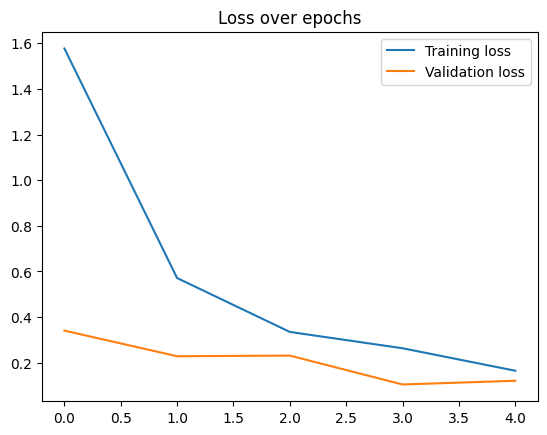

In [48]:
# plot losses

plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()